In [4]:
from pathlib import Path

import numpy as np
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI
from jaxpower import (compute_mesh_power, PowerSpectrumMultipoles, generate_gaussian_mesh, generate_anisotropic_gaussian_mesh, generate_uniform_particles, RealMeshField, ParticleField, FKPField,
                      compute_fkp_power, BinnedStatistic, WindowMatrix, MeshAttrs, BinAttrs, compute_mean_mesh_power, compute_mesh_window, compute_normalization, utils, create_sharding_mesh, make_particles_from_local, create_sharded_array, create_sharded_random, compute_fkp_normalization_and_shotnoise)

attrs = MeshAttrs(meshsize=(128,) * 3, boxsize=1000., boxcenter=1200.)
size = int(1e-4 * attrs.boxsize.prod())
data = generate_uniform_particles(attrs, size + 1, seed=42)
randoms = generate_uniform_particles(attrs, 4 * size + 1, seed=43)

cosmo = DESI()
pk = cosmo.get_fourier().pk_interpolator().to_1d(z=1.)

f, b = 0.8, 1.5
beta = f / b
kinedges = np.linspace(0.001, 0.7, 100)
kin = (kinedges[:-1] + kinedges[1:]) / 2.
ells = (0, 2, 4)
poles = jnp.array([(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pk(kin),
                    0.9 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pk(kin),
                    8. / 35 * beta ** 2 * pk(kin)])
theory = BinnedStatistic(x=[kin] * len(ells), edges=[kinedges] * len(ells), value=poles, projs=ells)
mesh = generate_anisotropic_gaussian_mesh(attrs, theory, seed=random.key(42), los='local', unitary_amplitude=True)
data = data.clone(weights=1. + mesh.read(data.positions))

In [5]:
fkp = FKPField(data, randoms, **attrs.clone(boxsize=2. * attrs.boxsize))  # x2 padding
norm, shotnoise_nonorm = compute_fkp_normalization_and_shotnoise(fkp)
#mesh = fkp.paint(resampler='tsc', interlacing=0, compensate=False, out='real')
mesh = fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
print(mesh.attrs)
bin = BinAttrs(mesh.attrs, edges={'step': 0.01})
poles = compute_mesh_power(mesh, bin=bin, ells=(0, 2, 4), los='firstpoint').clone(norm=norm, shotnoise_nonorm=shotnoise_nonorm)

MeshAttrs(meshsize=staticarray([128, 128, 128], dtype=int32), boxsize=Array([2000., 2000., 2000.], dtype=float64), boxcenter=Array([1200., 1200., 1200.], dtype=float64), dtype=dtype('float64'), fft_engine='jaxdecomp')


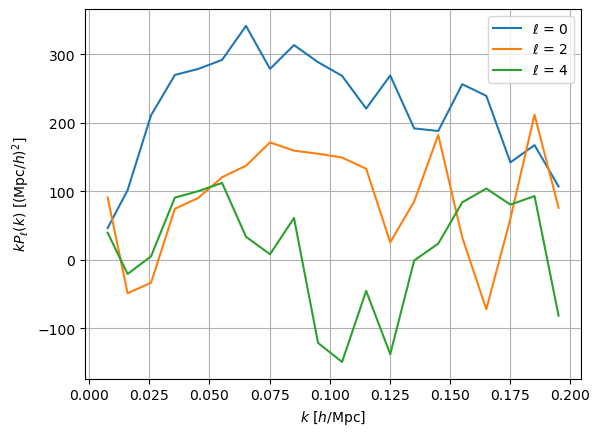

In [6]:
poles.plot(show=True);

In [7]:
import itertools
list_poles = {}
edges = {'step': 0.01}

for level, nsplits in enumerate([1, 2]):
    bin = None
    list_poles[level] = []
    for split_fkp in fkp.clone(meshsize=64).split(nsplits=nsplits):
        split_norm, split_shotnoise_nonorm = compute_fkp_normalization_and_shotnoise(split_fkp)
        mesh = split_fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
        # Compute mesh power spectrum
        if bin is None: bin = BinAttrs(mesh.attrs, edges=edges)
        print(mesh.attrs)
        split_poles = compute_mesh_power(mesh, bin=bin, ells=(0, 2, 4), los='firstpoint').clone(norm=split_norm, shotnoise_nonorm=split_shotnoise_nonorm)
        list_poles[level].append(split_poles)

MeshAttrs(meshsize=staticarray([64, 64, 64], dtype=int32), boxsize=Array([2000., 2000., 2000.], dtype=float64), boxcenter=Array([1200.00028238, 1200.0000179 , 1200.00129287], dtype=float64), dtype=dtype('float64'), fft_engine='jaxdecomp')
MeshAttrs(meshsize=staticarray([64, 64, 64], dtype=int32), boxsize=Array([1000., 1000., 1000.], dtype=float64), boxcenter=Array([950.00083693, 950.00072783, 950.00251153], dtype=float64), dtype=dtype('float64'), fft_engine='jaxdecomp')
MeshAttrs(meshsize=staticarray([64, 64, 64], dtype=int32), boxsize=Array([1000., 1000., 1000.], dtype=float64), boxcenter=Array([ 950.00083693,  950.00072783, 1450.0000742 ], dtype=float64), dtype=dtype('float64'), fft_engine='jaxdecomp')
MeshAttrs(meshsize=staticarray([64, 64, 64], dtype=int32), boxsize=Array([1000., 1000., 1000.], dtype=float64), boxcenter=Array([ 950.00083693, 1449.99930796,  950.00251153], dtype=float64), dtype=dtype('float64'), fft_engine='jaxdecomp')
MeshAttrs(meshsize=staticarray([64, 64, 64], dt

In [8]:
fnyq = 0.8
split_poles = []
for level in list_poles:
    kmin = 0
    kmax = np.inf
    if level < len(list_poles) - 1: kmax = fnyq * list_poles[level][0].edges(projs=0).max()
    if split_poles: kmin = split_poles[-1].edges(projs=0).max()
    split_poles.append(poles.sum([poles.select(xlim=(kmin, kmax)) for poles in list_poles[level]]))
split_poles = split_poles[0].concatenate(split_poles)

0 (0, Array(0.08, dtype=float64))
1 (Array(0.08, dtype=float64), inf)


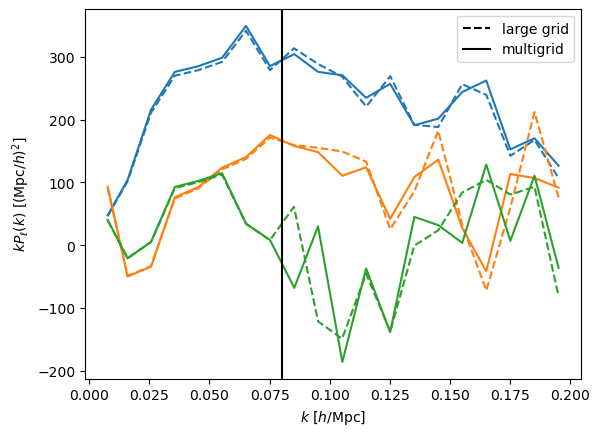

In [9]:
ax = plt.gca()
for iproj, proj in enumerate(poles.projs):
    color = 'C{:d}'.format(iproj)
    k = poles.x(projs=proj)
    ax.plot(k, k * poles.view(projs=proj).real, linestyle='--', color=color)
    k = split_poles.x(projs=proj)
    ax.plot(k, k * split_poles.view(projs=proj).real, linestyle='-', color=color)
ax.plot([], [], color='k', linestyle='--', label='large grid')
ax.plot([], [], color='k', linestyle='-', label='multigrid')
ax.axvline(x=list_poles[0][0].edges(projs=0)[-1] * fnyq, color='k')
ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
ax.legend()
plt.show()